# Chapter 4 - Data Preprocessing

Examining and preprocessing the dataset before feeding it to a ML-algorithm is essential for the perfomance of the algorithm. 
Three topics are covered
* Removing and imputing missing values from the dataset
* Getting categroical data into shape for machine learning algorithms
* Selecting relevant features for the model construction

## Missing data

Most computational tools are unable to handle missing values, or produce unpredictable results if we ingnore them. 

First we have to identify the missing data

In [21]:
#Creating CSV_data
import pandas as pd
from io import StringIO
#Create string of datapoints
csv_data = \
"""A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,"""

df = pd.read_csv(StringIO(csv_data)) #read string to csv file
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [22]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [23]:
df.values #creates the underlying Numpy array of the dataframe we made with Pandas. 
#Pandas is more conveniet to preprocess the data, scikit-learn was built on Numpy, 
#so converting to Numpy array can sometimes be useful.

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [26]:
#Rows/columns containing missing values can be deleted as follows
print(df.dropna(axis=0)) #Delete Rows
print(df.dropna(axis=1)) #Delete Columns
print(df.dropna(how='all')) #Drop rows in which all values are NaN
print(df.dropna(thresh=4)) #Drop rows that have less than 4 real values
print(df.dropna(subset=['C'])) #Only drop rows in which NAN appears in specific columns

     A    B    C    D
0  1.0  2.0  3.0  4.0
      A     B
0   1.0   2.0
1   5.0   6.0
2  10.0  11.0
      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN
     A    B    C    D
0  1.0  2.0  3.0  4.0
      A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN


## Imputing missing values

In [29]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

The imputer class belongs to the 'transformer classes' in scikit-learn which are used for data transformators. The two essential methods of these classes are 'fit' and 'transform'. Fit is used to learn the parameters from the training data, and transform uses those parameters to transform the data. 
Any data array that is to be transformed needs to have the same number of features as the data array that was used to fit the model.

Example of the book; fit the transformer on the training data and transform both the training and test set seperately

### Handiling Nominal and ordinal features

Examples of nominal and ordinal features --> T-shirt color (nominal, no order in labels) and T-shirt size (ordinal, order in labels (S<M<L))

In [37]:
import pandas as pd
df = pd.DataFrame([
                ['green', 'M', 10.1, 'class1'],
                 ['red', 'L', 13.5, 'class2'],
                 ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Mapping Ordinal features

To make sure ML-algorithms interpret the ordinal features correctly, the categorical string values can be converted to integers. No automatic function exist, so the mapping have to be defined manually.
Assumption: XL = L + 1, = M + 2

In [38]:
size_mapping = {
    'XL' : 3,
    'L' : 2,
    'M' : 1
}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [40]:
#To transform the integeres back to original string representation we can make an inverse mapping
inv_size_mapping = {v:k for k,v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### Encoding class labels

Many ML-libraries require that class labels (outcome labels) are encoded as integer values. Most scikit-learn estimators convert them internally, it is good practice to provide class labels as integer arrays to avoid glitches.
Classes (mainly) have no ordinal relation, so it does not matter which integer number we assign to a particular string label. We can simply enumerate the class labels, starting at 0

In [56]:
import numpy as np
class_mapping = {label:idx for idx, label in
                enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [57]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [58]:
#Reverse
inv_class_mapping = {v:k for k,v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


Alternatively, there is a convenient 'LabelEncoder' class directly implemented in scikit-learn to achieve this.
fit_transform is a shortcut to call both fit and transform at once

In [61]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values) 
y

array([0, 1, 0], dtype=int64)

In [62]:
#Inverse_transform can be used to transform integer class back to original string representations
class_le.inverse_transform(y)

C:\Users\rikkr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class1', 'class2', 'class1'], dtype=object)

## One-hot encoding on nominal features

In [63]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

As seen above, X now holds the values of the DF and the first column represents the color labels. A ML-algorithm will now assume that green (1) is larger than blue(0). This yields suboptimal results.
One-hot encoding creates a new dummy feature sfor each unique value, representing binary values for the presence of absence of that particular label.

In [64]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features = [0]) #Define column position of the variable that has to be transformed
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

By default a sparse matrix is returned when using the transform method. For visualiztion purposes the toarray method creates a normal (dense) matrix. Sparse matrices are more efficient way of storing large datasets and one that is supported by many scikit-learn functions. Encoder can be initialized with (OneHotEncoder(..., sparse = False)).

More convenient to create dummy features is by the get_dummies method implemented in Pandas. It wil convert string columns in a dataframe and leav all other columns unchanges.

In [68]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


One-hot encoding can introduce multicollinearity, which can be an issue for certain methods (ie; methods that require matrix inversion). Matrices with highly correlated variables are hard to invert, which can lead to numerically unstable estimates.

To reduce correlation among variables, we can simply remove a feature column (without losing information!). This can be done in the get_dummies function by passing True argument to the drop_first parameter.

In [74]:
pd.get_dummies(df[['price', 'color', 'size']], 
              drop_first = True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [76]:
#The same with OneHotEncoder is slightly less convenient, but can be done as follows
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:,1:]

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

## Partitioning a dataset into seperate training and test sets

In [79]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium',
                  'Total phenols', 'Flavanoids',
                  'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines',
                  'Proline']
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [80]:
#Most convenient method for splitting the dataset is using scikit-learn's train_test_split
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                    test_size = 0.3,
                    random_state = 0, 
                    stratify = y)

## Features scaling

Crucial step in preprocessing pipeline that is easily forgotten. Features scaling is not necessary in decision trees and random forests.

Two common approaches for feature scaling: Normalization and standardization.
* Normalization; often refers to rescaling features to a range of [0 1]. x(i) - x(min) / x(max) - x(min)
* Standardization; center features around mean 0 with an SD of 1. Mainly more useful as it provides a distribution similar to a normal distribution, maintains useful information about outliers and is less sensitive to outliers. x(i) - mean / SD

In [81]:
#MinMax scaler / Normalization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [82]:
#Standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Important: Fit parameters on training data and transform test data (and possibly new datapoints) with same parameters.

### Selecting meaningful features

Overfitting means that the model fits the parameters of the training set too coloesly but does not generalize well to new data (high variance). 
Solutions include 
* 1) collecting more training data
* 2) Introduce a penalty for complexity via regularization
* 3) Choose a simpler model with fewer parameters
* 4) Reduce the dimensionality of the data.

### L1 and L2 Regularization

* L2 regularization is most used to reduce complexity of the model by penalizing large individual weights (L2 is th esum of all squared weights). 
* L1 regularization can also be used (sum of all absolute weights) but yields sparse feature vectors in which most feature weights will be zero. In this sense L1-regularization can be understood as a technique for feature selection

In [90]:
#In scikit-learn we can simply set the penalty parameter to 'l1' in models that support L1 regularization
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty = 'l1')
lr = LogisticRegression(penalty = 'l1', C = 1.0) #C can be adjusted to in/decrease regularization effect
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy 1.0


In [91]:
lr.intercept_ #Similar to W0

array([-1.26323731, -1.21582515, -2.37027615])

Regression is fitted to multiclass dataset, and uses One-versus-All (OvR) by default (first intercept belongs to model that fits class 1 versus 2 and 3, second to model that fits class 2 versus 1 and 3 etc.)

In [92]:
lr.coef_ #Simlar to W1 to W(number of features)

array([[ 1.24557345,  0.18078091,  0.74219334, -1.15958081,  0.        ,
         0.        ,  1.17510727,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54112717,  2.51112527],
       [-1.53734212, -0.3872419 , -0.99500461,  0.36454469, -0.05960455,
         0.        ,  0.66809141,  0.        ,  0.        , -1.93404753,
         1.23394378,  0.        , -2.2322151 ],
       [ 0.1356546 ,  0.16838655,  0.35723077,  0.        ,  0.        ,
         0.        , -2.43813369,  0.        ,  0.        ,  1.5638381 ,
        -0.81881601, -0.49222492,  0.        ]])

In [93]:
lr.coef_[1]

array([-1.53734212, -0.3872419 , -0.99500461,  0.36454469, -0.05960455,
        0.        ,  0.66809141,  0.        ,  0.        , -1.93404753,
        1.23394378,  0.        , -2.2322151 ])

Several zero values are seen (which are irrelevant features according to the L1-regularization). The number of 0-values can be increased by increasing the regularization strength (choosing lower values for C)

Now we will plot the weight coefficients of the different features for different regularization strenghts.

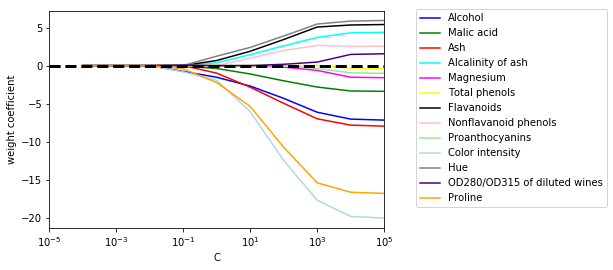

In [108]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot()

colors = ['blue', 'green', 'red', 'cyan',
         'magenta', 'yellow', 'black',
         'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4.0, 6.0):
    lr = LogisticRegression(penalty = 'l1',
                           C = 10.0**c,
                           random_state = 0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1]) #Coefficient of the first model of the OvA models
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
            label = df_wine.columns[column + 1],
            color = color)
plt.axhline(0,color = 'black', linestyle = '--', linewidth = 3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc = 'upper left')
ax.legend(loc = 'upper center',
         bbox_to_anchor=(1.38,1.03),
         ncol = 1, fancybox = True)
plt.show()

### Sequential feature selection algorithms

Dimensionality reduction can be done by feature selection, which is especially useful for unregularized models. Two maincategories exist: Feature selection (select a subset of the original features) and Feature extraction (extract information from existing features to create new features.

Sequential feature selectino algorithms aim to reduce an intial d-dimensional feature space to a k-dimensional feature subspace in which k<d. The motivation is to automatically select a subset of features that are most relevant to the problem to improve computational efficiensy or reduce the generalization error of the model by removing irrelevant features/noise.

A classic algoristm is Sequential Backward Selection (SBS), which aims to reduce dimensionality of the initial feature subspace with a minimum decay in performance of the classifier to imporove upon computational efficiency. SBS can sometimes improve predictive power in models suffering from overfitting.

The idea behind SBS is simple; remove features from the full feature subset until the model contains the desired number of features. We need to define the criterion J what we want to minimize after deleting a feature (this can simply be the performance of a classifier after removal of the feature). We then eliminate at each step the feature with the smallest loss in performance power.

* 1) Initialize the algorithm with k = d, where d is the dimensionality of the full feature space
* 2) Determine the feature x- that maximizes the criterion (x- = argmax J(Xk - x))
* 3) Remove the feature x- from the feature set: X k-1 = Xk - X- ; k = k-1
* 4) Terminate if k equals the number of desired features, otherwise go to step 2

In [116]:
#SBS is not (yet) implemented in scikit-learn
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                scoring = accuracy_score,
                test_size = 0.25, random_state =1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size = self.test_size,
                            random_state = self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r= dim -1):
                score = self._calc_score(X_train, y_train,
                                        X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [117]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train) #Althoug SBS internally splits the dataset 
#we use the training dataset to prevent the test set to become part of the training data

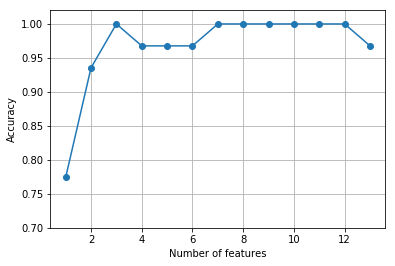

In [118]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [125]:
#Least number of features with 100% accuracy is 3, let's see which features are used in this model
k3 = list(sbs.subsets_[10])
df_wine.columns[1:][k3]

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')

In [126]:
#Evaluate the performance of the KNN classifier on the original test set (with all features)
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy 0.967741935483871
Test accuracy 0.9629629629629629


In [128]:
#Evaluate perfomance of the KNN classifier with 3 features
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


Slight decrease in test accuracy, despite descreasing the dataset. May be useful in real-world applications that may invlove expensive data collection steps.

Several other feature selection algorithms exist (ie recursive backward elimination), a good summary can be found on https://scikit-learn.org/stable/modules/feature_selection.html

### Assessing feature importance (random forests)

Using a random forest feature importance can be assessed (average impurity decrease computed from all decision trees). THe random forest implementation in scikit-learn automatically calculate feature importance.

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


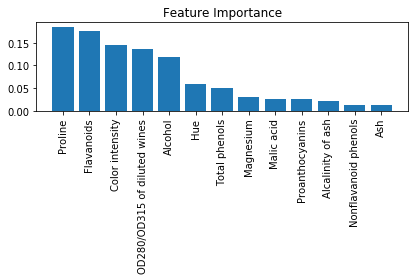

In [147]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 500, random_state =1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] #::-1 means reversed order

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]])) #-*s, uitlijnen links met 30 ruimte

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align = 'center')

plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()

Important: Multicollinearity in a dataset can cause problems with interpretation: If two features are highly correlated, one can have a very high importance, while the other has a ver low importance. Not important for interpretation of model accuracy, but be careful with interpretation of feature importance.

Scikitlearn also implements a SelectFrommodel object that selects features based on user-specified threshold after model fitting. In this way we can use the RandomForestClassifier as a feature selector and intermediat step in a scikit-learn Pipeline object.

In [149]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold = 0.1, prefit = True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold criterion:', X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indices[f]],
                           importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
